#  Policy Gradients

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Саттон Р. С., Барто Э. Дж. Обучение с подкреплением: Введение. 2-е изд.
* Лю Ю. (Х.) Обучение с подкреплением на PyTorch: сборник рецептов / пер. с англ. А. А. Слинкина. – М.: ДМК Пресс, 2020
* https://www.youtube.com/watch?v=_x0ASf9jV9U&ab_channel=sim0nsays
* https://karpathy.github.io/2016/05/31/rl/
* https://neerc.ifmo.ru/wiki/index.php?title=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_policy_gradient_%D0%B8_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B0%D1%81%D0%B8%D0%BD%D1%85%D1%80%D0%BE%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B0%D0%BA%D1%82%D0%BE%D1%80%D0%B0-%D0%BA%D1%80%D0%B8%D1%82%D0%B8%D0%BA%D0%B0
* https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html
* https://huggingface.co/learn/deep-rl-course/unit4/introduction
* https://lilianweng.github.io/posts/2018-04-08-policy-gradient/#:~:text=The%20goal%20of%20reinforcement%20learning,and%20optimizing%20the%20policy%20directly.

## Задачи для совместного разбора

1\. Рассмотрите основные шаги по формированию обучающей выборки для использования алгоритмов Policy Gradients.

In [ ]:
import torch as th

In [ ]:
state_dim = 5
n_actions = 3

state = th.rand(state_dim)

In [ ]:
import torch.nn as nn

In [ ]:
model = nn.Sequential(
    nn.Linear(state_dim, n_actions),
    nn.Softmax()
) # Для батчей dim=1

In [ ]:
predictios = model(state)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
model(state).sum().item()

1.0

In [ ]:
action = th.multinomial(predictios, 1).item()

In [ ]:
log_prob = predictios[action].log().item()
log_prob

-1.2364733219146729

In [ ]:
log_probs = []
rewards = []
# reset
for _ in range(10):
  predictions = model(state)
  action = th.multinomial(predictions, 1).item()
  log_prob = predictions[action].log()
  r = th.rand(1)

  log_probs.append(log_prob)
  rewards.append(r.item()) # rewards

  # R

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Допишите классы `Policy` для реализации модели политики и `Trainer` для реализации процесса обучения модели при помощи алгоритма REINFORCE. Настройте агента для игры в окружении `CartPole-v1`. Визуализируйте динамику значений награды на эпизод в процессе обучения. Сыграйте эпизод, используя обученного агента, и убедитесь, что агент выучивается, как стабилизировать шест.

$$L_{PG} = -\sum_{i}{R_ilogp(a_i|s_i)}$$

$$R_t = \sum_{k=0}^{\infty}\gamma^kr_{t+k}$$

где $r_t$ - награда за шаг $t$.


- [ ] Проверено на семинаре

In [1]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.3 MB/s eta 0:00:00


In [2]:
import torch as th
import gymnasium as gym
import torch.nn as nn
import torch.optim as optim

In [234]:
from dataclasses import dataclass
@dataclass
class PolicyConfig:
    n_state: int = 4
    n_actions: int = 2
    n_hidden: int = 50

In [235]:
class PolicyNetwork(nn.Module):
    def __init__(self, policy_config: PolicyConfig):
        super().__init__()
        self.cfg = policy_config
        self.model = nn.Sequential(
              nn.Linear(self.cfg.n_state, self.cfg.n_hidden),
              nn.ReLU(),
              nn.Linear(self.cfg.n_hidden, self.cfg.n_actions),
              nn.Softmax(dim=0)
          )

    def forward(self, s: th.Tensor) -> th.Tensor:
        return self.model(s)

    def get_action(self, s: th.Tensor) -> tuple[int, float]:
        # возвращает действие пропорционально вероятностям, полученным при помощи модели
        # и логарифм вероятности выбранного действия
        predictions = self.forward(s)
        action = th.multinomial(predictions, 1).item()
        log_prob = predictions[action].log()
        return action, log_prob

In [264]:
from dataclasses import dataclass

@dataclass
class TrainConfig:
    gamma: float = 0.99
    learning_rate: float = 0.01
    episode_num: float = 300

In [265]:
from tqdm import tqdm
class Trainer:
    def __init__(self, train_cfg, policy, env):
        self.cfg = train_cfg
        self.policy = policy
        self.env = env
        self.optimizer = optim.Adam(policy.model.parameters(), lr=self.cfg.learning_rate)

    def select_action(self, state):
        return self.policy.get_action(state)

    def run_episode(self):
        rewards = []
        log_probs = []
        done = False
        reward_sum = 0
        state, info = self.env.reset()
        while not done:
          action, log_prob = self.select_action(th.tensor(state))
          log_probs.append(log_prob.unsqueeze(0))
          state, reward, terminated, truncated, info = self.env.step(action)
          reward_sum += reward
          rewards.append(reward)
          done = truncated or terminated
        return rewards, log_probs, reward_sum

    def train(self):
        reward_sums = []
        for ep in tqdm(range(self.cfg.episode_num)):
            R = []
            rewards, log_probs, reward_sum = self.run_episode()
            reward_sums.append(reward_sum)
            rewards = th.tensor(rewards)
            log_probs = th.cat(log_probs)
            gammas = self.cfg.gamma ** th.arange(len(rewards))
            for i in range(len(rewards)):
                s = th.sum(gammas[:len(rewards)-i] * rewards[i:])
                R.append(s)
            R = th.tensor(R)
            L_PG = - th.sum(log_probs * R)
            L_PG.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
        return reward_sums

In [266]:
#env = gym.make('CartPole-v1')
env = gym.wrappers.RecordEpisodeStatistics(gym.make('CartPole-v1'), deque_size=400)

obs, _ = env.reset()

In [267]:
pol = PolicyNetwork(PolicyConfig())
car = Trainer(TrainConfig(), pol, env)

In [270]:
reward_sum = car.train()

100%|██████████| 300/300 [00:36<00:00,  8.21it/s]


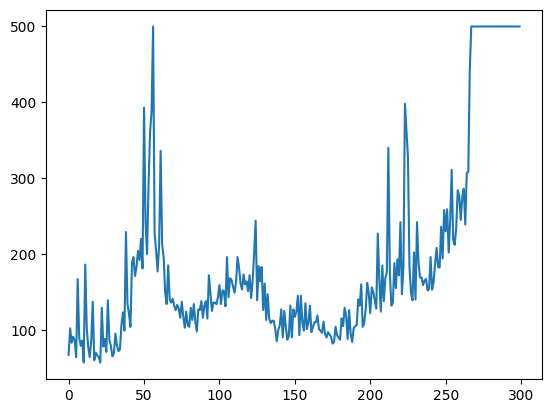

In [271]:
plt.plot(reward_sum);

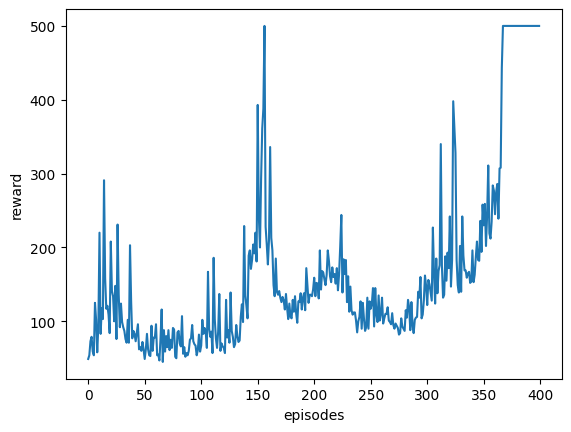

In [272]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.array(env.return_queue))
plt.xlabel('episodes')
plt.ylabel('reward');

In [273]:
env = gym.wrappers.RecordVideo(gym.make('CartPole-v1', render_mode='rgb_array'), 'cartpole0')
state, info = env.reset()
done = False

k = 0
while not done:
  env.render()
  action = pol.get_action(th.tensor(state))[0]
  k += 1
  state, reward, terminated, truncated, info = env.step(action)
  done = truncated or terminated
env.close()
print(k)

Moviepy - Building video /content/cartpole0/rl-video-episode-0.mp4.
Moviepy - Writing video /content/cartpole0/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/cartpole0/rl-video-episode-0.mp4
500


<p class="task" id="2"></p>

2\. Повторите решение задачи 1, делая шаг обучения не после одного эпизода, а по результату прогонов нескольких эпизодов. Обратите внимание, что после обновления весов модели все старые данные для обучения становятся неактуальными и должны быть удалены.

- [ ] Проверено на семинаре

In [275]:
from dataclasses import dataclass

@dataclass
class TrainConfig:
    gamma: float = 0.99
    learning_rate: float = 0.01
    episode_num: float = 40

In [276]:
class Trainer_batch(Trainer):
    def __init__(self, train_cfg, policy, env):
        super().__init__(train_cfg, policy, env)

    def train(self):
        reward_sums = []
        for ep in tqdm(range(self.cfg.episode_num)):
            L_PG = []
            for _ in range(10):
                R = []
                rewards, log_probs, reward_sum = self.run_episode()
                reward_sums.append(reward_sum)
                rewards = th.tensor(rewards)
                log_probs = th.cat(log_probs)
                gammas = self.cfg.gamma ** th.arange(len(rewards))
                for i in range(len(rewards)):
                    s = th.sum(gammas[:len(rewards)-i] * rewards[i:])
                    R.append(s)
                R = th.tensor(R)
                L_PG.append((- th.sum(log_probs * R)).unsqueeze(0))
            L_PG = th.cat(L_PG).sum()
            L_PG.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
        return reward_sums

In [277]:
#env = gym.make('CartPole-v1')
env = gym.wrappers.RecordEpisodeStatistics(gym.make('CartPole-v1'), deque_size=400)

obs, _ = env.reset()

In [278]:
pol = PolicyNetwork(PolicyConfig())
car = Trainer_batch(TrainConfig(), pol, env)

In [281]:
reward_sums = car.train()

100%|██████████| 40/40 [01:11<00:00,  1.78s/it]


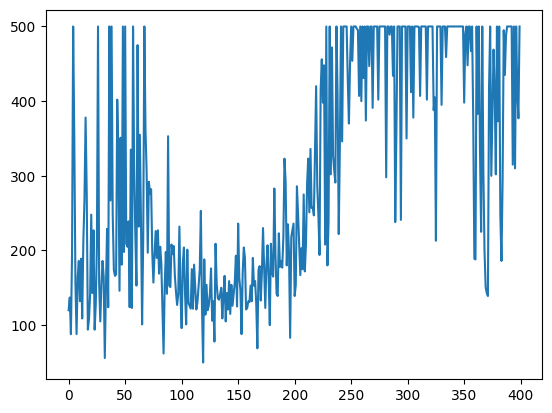

In [282]:
import matplotlib.pyplot as plt

plt.plot(reward_sums);

In [283]:
env = gym.wrappers.RecordVideo(gym.make('CartPole-v1', render_mode='rgb_array'), 'cartpole3')
state, info = env.reset()
done = False

k = 0
while not done:
  env.render()
  action = pol.get_action(th.tensor(state))[0]
  k += 1
  state, reward, terminated, truncated, info = env.step(action)
  done = truncated or terminated
env.close()
print(k)

Moviepy - Building video /content/cartpole3/rl-video-episode-0.mp4.
Moviepy - Writing video /content/cartpole3/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/cartpole3/rl-video-episode-0.mp4
500


<p class="task" id="3"></p>

3\. Повторите решение задачи 1, реализовав алгоритм REINFONCE с baseline.

$$L_{PG} = -\sum_{i}{A_ilogp(a_i|s_i)}$$

$$A_i = R_i - V(s_i)$$

$$R_t = \sum_{k=0}^{\infty}\gamma^kr_{t+k}$$

где $r_t$ - награда за шаг $t$.

$p(a_i|s_i)$ и $V(s_i)$ моделируются при помощи двух независимых сетей. Сеть для политики настраивается аналогично задаче 1 и 2 при помощи функции потерь $L_{PG}$. Сеть для оценки базы настраивается в процессе решения задачи регрессии: $L_{V} = \sum_i(V(s_i) - R_i)^2$. Настройка весов обеих моделей происходит после каждого эпизода.

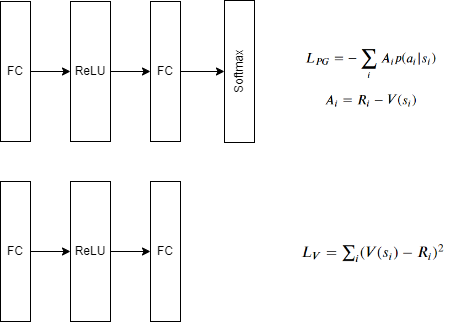

- [ ] Проверено на семинаре

In [155]:
class PolicyNetwork3(nn.Module):
    def __init__(self, policy_config: PolicyConfig):
        super().__init__()
        self.cfg = policy_config
        self.model1 = nn.Sequential(
              nn.Linear(self.cfg.n_state, self.cfg.n_hidden),
              nn.ReLU(),
              nn.Linear(self.cfg.n_hidden, self.cfg.n_actions),
              nn.Softmax(dim=0)
          )
        self.model2 = nn.Sequential(
              nn.Linear(self.cfg.n_state, self.cfg.n_hidden),
              nn.ReLU(),
              nn.Linear(self.cfg.n_hidden, 1)
        )

    def forward_estim(self, s):
        return self.model2(s)

    def forward(self, s: th.Tensor) -> th.Tensor:
        return self.model1(s)

    def get_action(self, s: th.Tensor) -> tuple[int, float]:
        # возвращает действие пропорционально вероятностям, полученным при помощи модели
        # и логарифм вероятности выбранного действия
        estim = self.forward_estim(s)
        predictions = self.forward(s)
        action = th.multinomial(predictions, 1).item()
        log_prob = predictions[action].log()
        return action, log_prob, estim

In [214]:
@dataclass
class TrainConfig:
    gamma: float = 0.99
    learning_rate: float = 0.001
    episode_num: float = 350

In [215]:
class Trainer_baseline:
    def __init__(self, train_cfg, policy, env):
        self.cfg = train_cfg
        self.policy = policy
        self.env = env
        self.optimizer1 = optim.Adam(policy.model1.parameters(), lr=self.cfg.learning_rate)
        self.optimizer2 = optim.Adam(policy.model2.parameters(), lr=self.cfg.learning_rate)

    def select_action(self, state):
        return self.policy.get_action(state)

    def run_episode(self):
        rewards = []
        log_probs = []
        estims = []
        done = False
        reward_sum = 0
        state, info = self.env.reset()
        while not done:
          action, log_prob, estim = self.select_action(th.tensor(state))
          log_probs.append(log_prob.unsqueeze(0))
          estims.append(estim.unsqueeze(0))
          state, reward, terminated, truncated, info = self.env.step(action)
          reward_sum += reward
          rewards.append(reward)
          done = truncated or terminated
        return rewards, log_probs, estims, reward_sum

    def train(self):
        reward_sums = []
        for ep in tqdm(range(self.cfg.episode_num)):
            R = []
            rewards, log_probs, estims, reward_sum = self.run_episode()
            reward_sums.append(reward_sum)
            rewards = th.tensor(rewards)
            log_probs = th.cat(log_probs)
            estims = th.cat(estims)
            gammas = self.cfg.gamma ** th.arange(len(rewards))
            for i in range(len(rewards)):
                s = th.sum(gammas[:len(rewards)-i] * rewards[i:])
                R.append(s)
            R = th.tensor(R)

            L_V = th.sum((estims - R) ** 2)
            L_V.backward()
            self.optimizer2.step()
            self.optimizer2.zero_grad()

            A = R - estims.detach()

            L_PG = - th.sum(log_probs * A)
            L_PG.backward()
            self.optimizer1.step()
            self.optimizer1.zero_grad()
        return reward_sums

In [216]:
env = gym.wrappers.RecordEpisodeStatistics(gym.make('CartPole-v1'), deque_size=300)
obs, _ = env.reset()

In [217]:
pol = PolicyNetwork3(PolicyConfig())
car = Trainer_baseline(TrainConfig(), pol, env)

In [218]:
reward_sums = car.train()

100%|██████████| 350/350 [00:41<00:00,  8.41it/s]


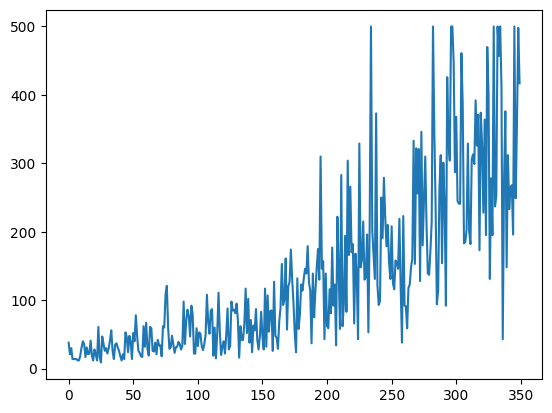

In [219]:
plt.plot(reward_sums);

In [221]:
env = gym.wrappers.RecordVideo(gym.make('CartPole-v1', render_mode='rgb_array'), 'cartpole3')
state, info = env.reset()
done = False

k = 0
while not done:
  env.render()
  action = pol.get_action(th.tensor(state))[0]
  k += 1
  state, reward, terminated, truncated, info = env.step(action)
  done = truncated or terminated
env.close()
print(k)

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/cartpole3 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/cartpole3/rl-video-episode-0.mp4.
Moviepy - Writing video /content/cartpole3/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/cartpole3/rl-video-episode-0.mp4
431


<p class="task" id="4"></p>

4\. Повторите решение задачи 1, реализовав алгоритм Actor-Critic

$$L_{PG} = -\sum_{i}{A_ip(a_i|s_i)}$$

$$A_i = R_i - V(s_i)$$

$$R_t = \sum_{k=0}^{\infty}\gamma^kr_{t+k}$$

где $r_t$ - награда за шаг $t$.

$p(a_i|s_i)$ и $V(s_i)$ моделируются при помощи одной сети в двумя головами. Голова для политики настраивается аналогично задаче 1 и 2 при помощи функции потерь $L_{PG}$. Голова для оценки базы настраивается в процессе решения задачи регрессии: $L_{V} = \sum_i(V(s_i) - R_i)^2$. Итоговая функции потерь для настройки представляет из себя сумму функций потерь для голов: $L = L_{PG} + L_{V}$.

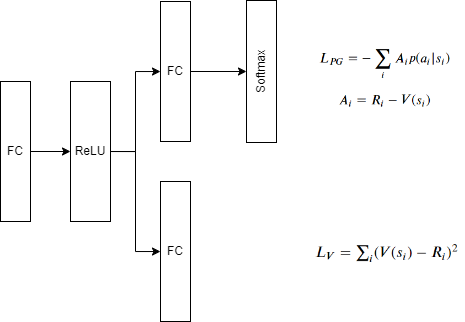

- [ ] Проверено на семинаре

In [308]:
class Model(nn.Module):
    def __init__(self, policy_config):
        super().__init__()
        self.fc = nn.Linear(policy_config.n_state, policy_config.n_hidden)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(policy_config.n_hidden, policy_config.n_actions)
        self.softmax = nn.Softmax(dim=0)
        self.fc2 = nn.Linear(policy_config.n_hidden, 1)

    def forward(self, s: th.Tensor) -> th.Tensor:
        out = self.fc(s)
        out = self.relu(out)
        prediction = self.fc1(out)
        prediction = self.softmax(prediction)
        estim = self.fc2(out)
        return prediction, estim

In [426]:
@dataclass
class PolicyConfig:
    n_state: int = 4
    n_actions: int = 2
    n_hidden: int = 25

In [441]:
@dataclass
class TrainConfig:
    gamma: float = 0.99
    learning_rate: float = 0.001
    episode_num: float = 2500

In [442]:
class PolicyNetwork4(nn.Module):
    def __init__(self, policy_config: PolicyConfig):
        super().__init__()
        self.cfg = policy_config
        self.model = Model(policy_config)

    def forward(self, s: th.Tensor) -> th.Tensor:
        predictions, estim = self.model(s)
        return predictions, estim

    def get_action(self, s: th.Tensor) -> tuple[int, float]:
        # возвращает действие пропорционально вероятностям, полученным при помощи модели
        # и логарифм вероятности выбранного действия
        predictions, estim = self.forward(s)
        action = th.multinomial(predictions, 1).item()
        log_prob = predictions[action].log()
        return action, log_prob, estim

In [443]:
class Trainer_Actor_Critic(Trainer):
    def __init__(self, train_cfg, policy, env):
        self, train_cfg, policy, env
        self.cfg = train_cfg
        self.policy = policy
        self.env = env
        self.optimizer = optim.Adam(policy.model.parameters(), lr=self.cfg.learning_rate)

    def select_action(self, state):
        return self.policy.get_action(state)

    def run_episode(self):
        rewards = []
        log_probs = []
        estims = []
        done = False
        reward_sum = 0
        state, info = self.env.reset()
        while not done:
          action, log_prob, estim = self.select_action(th.tensor(state))
          log_probs.append(log_prob.unsqueeze(0))
          estims.append(estim.unsqueeze(0))
          state, reward, terminated, truncated, info = self.env.step(action)
          reward_sum += reward
          rewards.append(reward)
          done = truncated or terminated
        return rewards, log_probs, estims, reward_sum

    def train(self):
        reward_sums = []
        for ep in tqdm(range(self.cfg.episode_num)):
            R = []
            rewards, log_probs, estims, reward_sum = self.run_episode()
            reward_sums.append(reward_sum)
            rewards = th.tensor(rewards)
            log_probs = th.cat(log_probs)
            estims = th.cat(estims)
            gammas = self.cfg.gamma ** th.arange(len(rewards))
            for i in range(len(rewards)):
                s = th.sum(gammas[:len(rewards)-i] * rewards[i:])
                R.append(s)
            R = th.tensor(R)

            L_V = th.sum((estims - R) ** 2)
            A = R - estims
            L_PG = - th.sum(log_probs * A)
            L = L_PG + L_V

            L.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
        return reward_sums

In [444]:
env = gym.wrappers.RecordEpisodeStatistics(gym.make('CartPole-v1'), deque_size=300)
obs, _ = env.reset()

In [445]:
pol = PolicyNetwork4(PolicyConfig())
car = Trainer_Actor_Critic(TrainConfig(), pol, env)

In [446]:
reward_sums = car.train()

100%|██████████| 2500/2500 [08:41<00:00,  4.79it/s]


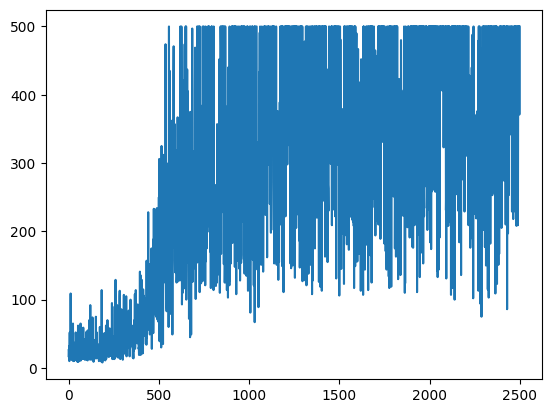

In [447]:
plt.plot(reward_sums);

In [449]:
env = gym.wrappers.RecordVideo(gym.make('CartPole-v1', render_mode='rgb_array'), 'cartpole5')
state, info = env.reset()
done = False

k = 0
while not done:
  env.render()
  action = pol.get_action(th.tensor(state))[0]
  k += 1
  state, reward, terminated, truncated, info = env.step(action)
  done = truncated or terminated
env.close()
print(k)

Moviepy - Building video /content/cartpole5/rl-video-episode-0.mp4.
Moviepy - Writing video /content/cartpole5/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/cartpole5/rl-video-episode-0.mp4
500


## Обратная связь
- [x] Хочу получить обратную связь по решению